## Структура БД

<img src="db_structure.jpg"
     alt="database"/>

Найдите количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года. Назовите получившееся поле flights_amount и выведите его. Также напечатайте на экране поле model. Столбцы в таблице должны быть выведены в следующем порядке:
- model
- flights_amount

```python
SELECT
    a.model AS model,
    COUNT(f.flight_id) AS flights_amount
FROM
    aircrafts AS a
    INNER JOIN flights AS f ON f.aircraft_code = a.aircraft_code
WHERE
    CAST(f.departure_time AS date) BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY
    model;

```

Посчитайте количество рейсов по всем моделям самолётов Boeing, Airbus и другим ('other') в сентябре. Типы моделей поместите в столбец type_aircraft, а количество рейсов — во flights_amount. Выведите их на экран.

```python

SELECT
    CASE
        WHEN aircrafts.model LIKE '%Boeing%' THEN 'Boeing'
        WHEN aircrafts.model LIKE '%Airbus%' THEN 'Airbus'
        ELSE 'other'
    END AS type_aircraft,
    COUNT(flights.flight_id) AS flights_amount
FROM flights
    INNER JOIN
    aircrafts
    ON flights.aircraft_code = aircrafts.aircraft_code
WHERE
    CAST(flights.departure_time AS date) BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY
    type_aircraft

```

Посчитайте среднее количество прибывающих рейсов в день для каждого города за август 2018 года. Назовите получившееся поле average_flights, вместе с ним выведите столбец city.

```python

SELECT
    city,
    AVG(arrival_cnt) AS average_flights
FROM
    (SELECT
        airports.city AS city,
        EXTRACT(DAY FROM flights.arrival_time) AS arrival_day,
        COUNT(flights.flight_id) AS arrival_cnt
    FROM
        flights
    INNER JOIN
        airports ON flights.arrival_airport = airports.airport_code
    WHERE
        CAST(flights.departure_time  AS date) BETWEEN '2018-08-01' AND '2018-08-31'
   GROUP BY
       city,
       arrival_day) AS sub
GROUP BY
    city;

```

Установите фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. Выведите название фестиваля festival_name и номер недели festival_week.

```python

SELECT 
    festival_name,
    EXTRACT(WEEK FROM festival_date) AS festival_week
FROM 
    festivals
WHERE
    (festival_date :: date BETWEEN '2018-07-23' AND '2018-09-30') AND
    (festival_city = 'Москва')
GROUP BY
    festival_name,
    festival_week
    
```

Для каждой недели с 23 июля по 30 сентября 2018 года посчитайте количество билетов, купленных на рейсы в Москву (номер недели week_number и количество билетов ticket_amount). Получите таблицу, в которой будет информация о количестве купленных за неделю билетов; отметка, проходил ли в эту неделю фестиваль; название фестиваля festival_name и номер недели week_number.
Выводите столбцы в таком порядке: - week_number - ticket_amount - festival_week - festival_name

```python

SELECT
    T.week_number,
    T.ticket_amount,
    T.festival_week,
    T.festival_name
FROM (
    (SELECT
        EXTRACT(WEEK FROM flights.arrival_time) AS week_number,
        COUNT(ticket_flights.ticket_no) AS ticket_amount
    FROM 
        flights
        INNER JOIN airports ON flights.arrival_airport = airports.airport_code
        INNER JOIN ticket_flights ON ticket_flights.flight_id = flights.flight_id 
    WHERE
        (airports.city = 'Москва') AND
        (flights.arrival_time :: date BETWEEN '2018-07-23' AND '2018-09-30')
    GROUP BY
        week_number) T1 LEFT JOIN
        (SELECT 
            festival_name,
            EXTRACT(WEEK FROM festival_date) AS festival_week
        FROM 
            festivals
        WHERE
            (festival_date :: date BETWEEN '2018-07-23' AND '2018-09-30') AND
            (festival_city = 'Москва')
        GROUP BY
            festival_name,
            festival_week
        ) T2 ON T1.week_number = T2.festival_week ) AS T
    
```

# Аналитика Авиакомпании

## Шаг 4. Аналитика средствами Python

Загрузим результаты первого и третьего запроса в тренажере.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

query_1 = pd.read_csv('query_1.csv')
query_3 = pd.read_csv('query_3.csv')

print(query_1.info())
print()
print(query_3.info())
print()
query_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None



,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [2]:
query_3.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


In [3]:
top_cities = query_3.sort_values(by='average_flights', ascending=False)['city'].head(10).values
#Напечатаем их
query_3.sort_values(by='average_flights', ascending=False).head(10)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


In [4]:
#Для графиков отсортируем датасеты
query_1.sort_values(by='flights_amount', ascending=False, inplace=True)
query_3.sort_values(by='average_flights', ascending=False, inplace=True)

Отобразим зависимости между моделями самолетов и количеством рейсов, а также между топ-10 городами и средним количеством рейсов.

Все города отображать не будем, так как после топ-10 все они остаются примерно на одной высоте, что не несет в себе полезной информации.

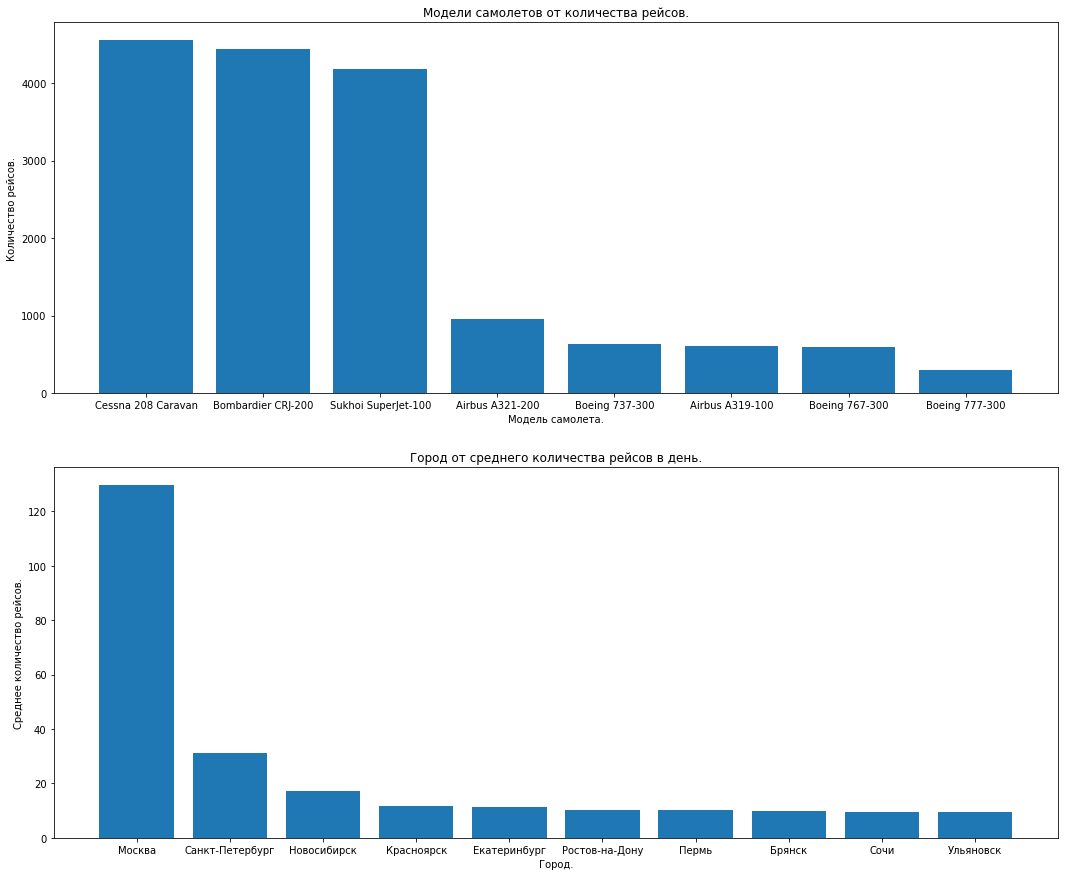

In [5]:
fig,ax = plt.subplots(2,1)

ax[0].bar(query_1['model'], query_1['flights_amount'])
ax[0].set_title('Модели самолетов от количества рейсов.')
ax[0].set_xlabel('Модель самолета.')
ax[0].set_ylabel('Количество рейсов.')

ax[1].bar(query_3['city'].head(10), query_3['average_flights'].head(10))
ax[1].set_title('Город от среднего количества рейсов в день.')
ax[1].set_xlabel('Город.')
ax[1].set_ylabel('Среднее количество рейсов.')

fig.set_size_inches(18,15)

plt.show()

Среди моделей самолетов самыми загруженными бывают Cessna 208 Caravan, Bombardier CRJ-200, Sukhoi Superjet-100. Дальность полета первой модели - 1200 км, второй - около 2000 км, а третьей - около 3000 км. Учитывая, что самым частым городом прибытия является Москва, то Cessna определенно летает только по России. Скорее всего это больше развлекательный или тренировочный самолет, так как мест в нем на 13 человек. Bombardier скорее всего тоже чаще летает по России. Superjet может летать как по России, так и по странам СНГ и по Европе.

Вообще логично, что Cessna летает чаще всех, ведь это маленький самолет, который подготовить для полета и найти пассажиров легче, чем для обычных среднемагистральных самолетов на 100+ человек. Ту же логику можно применить и к сравнению второй и третьей модели.

## Шаг 5. Проверка гипотезы средствами Python

Необходимо проверить гипотезу: Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.

$H_0$: Средний спрос на билеты во время фестивалей и в обычное время одинаковый.

$H_1$: Средний спрос на билеты во время фестивалей и в обычное время разный.

Для начала загрузим данные и взглянем на них.

In [6]:
last_query = pd.read_csv('query_last.csv')

print(last_query.info())
print()
last_query

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   week_number    10 non-null     int64  
 1   ticket_amount  10 non-null     int64  
 2   festival_week  3 non-null      float64
 3   festival_name  3 non-null      object 
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes
None



,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


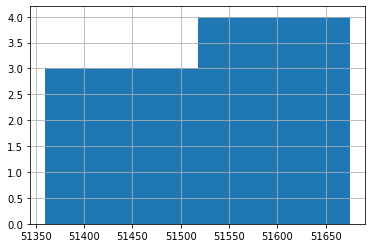

In [7]:
#Показать, что данные далеки от нормального распределения
last_query[last_query['festival_week'].isnull()]['ticket_amount'].hist(bins='fd')
plt.show()

Первый вывод - данных очень мало для надежной оценки. К тому же данные далеки от нормального распределения, поэтму воспользуемся Mann-Whitney U Test.

In [8]:
non_festival_mean = last_query[last_query['festival_week'].isnull()]['ticket_amount'].mean()
festival_mean     = last_query[last_query['festival_week'].notnull()]['ticket_amount'].mean()

print('Среднее количество проданных билетов в обычное время:      {:.2f}'.format(non_festival_mean))
print('Среднее количество проданных билетов вво время фестивалей: {:.2f}'.format(festival_mean))

alpha = .05

U,p = stats.mannwhitneyu(last_query[last_query['festival_week'].isnull()]['ticket_amount'].values, \
                                                   last_query[last_query['festival_week'].notnull()]['ticket_amount'].values)
print('p-value = ' + str(p))

if(p < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем')

Среднее количество проданных билетов в обычное время:      51530.86
Среднее количество проданных билетов вво время фестивалей: 48662.67
p-value = 0.03412374418900064
Отвергаем нулевую гипотезу


## Вывод

Полученное значение pvalue говорит нам о том, что с вероятностью 3.4% та разница в среднем количестве проданных билетов получена случайно. Данное значение ниже заданного критического уровня значимости, следовательно, мы отверагем нулевую гипотезу.

Предполагаем, что среднее количество проданных билетов в недели фестивалей <b>отличается</b> от среднего количества проданных билетов в обычные недели.